In [272]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [40]:
import json

dataset = json.load(open('Robert_Frost_Poem_Collections.json'))

titles = []
contents = []
for item in dataset:
  titles.append(item.get('title'))
  contents.append(item.get('content'))

training_text = ''.join(contents)

with open('training_text.txt', 'w+', encoding='utf-8') as f:
    f.write(training_text)

In [58]:
import sentencepiece as spm

class Tokenizer:
    def __init__(self, vocab_size= 2906, model_file='spm_vocab.model'):
        self.vocab_size = vocab_size
        self.model_file = model_file
        self.special_tokens = {
            '<PADDING>': 0,
            '<STARTLINE>': 1,
            '<ENDLINE>': 2,
            '<UNKNOWN>': 3
        }
        self.tokenizer = None
        self.train()
        self.tokenizer = spm.SentencePieceProcessor(model_file=self.model_file)     # type: ignore
        self.max_pad_length = self._find_max_token_length('training_text.txt')
        self._build_vocab()

    def train(self):
        spm.SentencePieceTrainer.train(                                             # type: ignore
            input='training_text.txt',
            model_prefix='spm_vocab',
            vocab_size=self.vocab_size,
            model_type='unigram',
            pad_id=self.special_tokens['<PADDING>'],
            unk_id=self.special_tokens['<UNKNOWN>'],
            bos_id=self.special_tokens['<STARTLINE>'],
            eos_id=self.special_tokens['<ENDLINE>'],
            user_defined_symbols=list(self.special_tokens.keys())
        )

    def _find_max_token_length(self, file_path):
        max_length = 0

        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                tokens = self.tokenizer.encode_as_pieces(line)                     # type: ignore
                max_length = max(max_length, len(tokens))

        return max(max_length,40)

    def _build_vocab(self):
        self.vocab = {token: idx for token, idx in self.special_tokens.items()}

        for id in range(self.tokenizer.get_piece_size()):                           # type: ignore
            piece = self.tokenizer.id_to_piece(id)                                  # type: ignore
            if piece not in self.vocab:
                self.vocab[piece] = len(self.vocab)

        self.reverse_vocab = {v: k for k, v in self.vocab.items()}

    def encode(self, text, method="int", pad_output=False):
        if method == "int": encoded = [self.special_tokens['<STARTLINE>']] + self.tokenizer.encode_as_ids(text) + [self.special_tokens['<ENDLINE>']]       # type: ignore
        else: encoded = ['<STARTLINE>'] + self.tokenizer.encode_as_pieces(text) + ['<ENDLINE>']             # type: ignore


        if pad_output:
            encoded = encoded[:self.max_pad_length]
            padding_needed = self.max_pad_length - len(encoded)
            if padding_needed > 0:
                if (method == "int") : encoded += [self.special_tokens['<PADDING>']] * padding_needed
                else : encoded += ['<PADDING>'] * padding_needed

        return encoded


    def decode(self, ids, method="int"):
        if method == "int":
            ids = [id for id in ids if id not in [self.special_tokens['<STARTLINE>'], self.special_tokens['<ENDLINE>']]]
            return self.tokenizer.decode_ids(ids)                                                                           # type: ignore
        else:
            pieces = [piece for piece in ids if piece not in ['<STARTLINE>', '<ENDLINE>', '<PADDING>']]
            return self.tokenizer.decode_pieces(pieces)                                                                     # type: ignore

    def create_input_output(self, dataset):
        inputs = []

        for lines in dataset:
            encoded_sentences = self.encode(lines, pad_output=True)
            inputs.append(torch.tensor(encoded_sentences, dtype=torch.long))

        inputs = torch.stack(inputs)

        return inputs

In [ ]:
tokenizer = Tokenizer()

Text_Dataset = [lines for content in contents for lines in content.split('\r\n')]

inp = tokenizer.create_input_output(Text_Dataset)
print(f"Input Data shape is  : {inp.shape}")

dataloader = DataLoader(inp, batch_size = 16, shuffle=True)               # type: ignore

In [258]:
class Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, layers, output_size,emb_size = 256):
        super(Predictor, self).__init__()

        self.embedding = nn.Embedding(input_size,emb_size)
        self.mlb = nn.Sequential(nn.Linear(emb_size,emb_size), nn.LayerNorm(emb_size) , nn.ELU() , nn.Linear(emb_size,emb_size))
        self.lstm = nn.LSTM(emb_size, hidden_size, num_layers=layers, batch_first=True, dropout=0.2)
        self.out = nn.Sequential(nn.Linear(hidden_size,hidden_size//2), nn.LayerNorm(hidden_size//2), nn.ELU(), nn.Dropout(0.5), nn.Linear(hidden_size//2 , output_size))

    def forward(self, input_seq, hidden, mem):
        input_emb = self.embedding(input_seq)
        input_emb = self.mlb(input_emb)
        output , (hidden_out , memory_out) = self.lstm(input_emb,(hidden,mem))

        return self.out(output) , hidden_out , memory_out


In [268]:
input_size = tokenizer.vocab_size
output_size = tokenizer.vocab_size
hidden_size = 256
layers = 2
epochs = 20
batch_size = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Predictor(input_size, hidden_size, layers, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)                #type: ignore
loss_fn = nn.CrossEntropyLoss()
lost_logs = []

for epoch in range(epochs):
    steps = 0
    model.train()
    loss = 0

    for text in dataloader:
        input = text[:,0:-1].to(device)
        output = text[:,1:].to(device)

        hidden = torch.zeros(layers, input.shape[0], hidden_size).to(device)
        cell = torch.zeros(layers, input.shape[0], hidden_size).to(device)

        pred,hidden,cell = model(input, hidden, cell)
        pred = pred.transpose(1,2)
        pred = pred.float()
    
        loss = loss_fn(pred, output)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        lost_logs.append(loss)

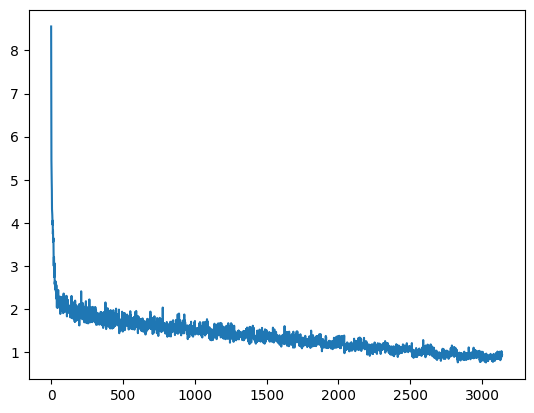

In [269]:
lost_logs = [i.item() for i in lost_logs]
plt.plot(lost_logs)
plt.show()

In [271]:
def sample_from_logits(logits, temperature):
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).item()

def generate_text(model, start_sequence, max_length, device, temperature=1.0):
    model.eval()
    generated_sequence = start_sequence
    input_seq = torch.tensor(start_sequence).unsqueeze(0).to(device)
    hidden = torch.zeros(layers, 1, hidden_size).to(device)
    mem = torch.zeros(layers, 1, hidden_size).to(device)

    for _ in range(max_length):
        with torch.no_grad(): output, hidden, mem = model(input_seq, hidden, mem)
        
        logits = output[:, -1, :]
    
        predicted_token = sample_from_logits(logits, temperature)
        generated_sequence.append(predicted_token)
        input_seq = torch.tensor(generated_sequence[-len(start_sequence):]).unsqueeze(0).to(device)

    return generated_sequence

max_length = 100  
temperature = 0.7
poem = []

for _ in range(5):
    start_sequence = [tokenizer.vocab.get('<STARTLINE>')]  
    generated_tokens = generate_text(model, start_sequence, max_length, device, temperature)
    poem.append(tokenizer.decode(generated_tokens))

for lines in poem : print(lines)

But the fun wouldn't let me forget the company.
He found him sureed the way I was,
And now I'm not so bad in the such a daunt,
He may be good, when you have to go.
That is all? You just let him stay. You know me.
